# Info

Notebook to use the measuered fluorescence spectrum, lifetime and refractive index to estimate the absorption and emission cross sections.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import peakutils
from numpy import exp, e
from scipy.constants import h, k, c, hbar, pi, C2K, centi, milli, micro, nano, lambda2nu
from scipy.optimize import curve_fit
from peakutils.plot import plot as pplot

%matplotlib notebook

In [19]:
plt.style.use('https://raw.githubusercontent.com/mn14tm/Notebooks/master/journal.mplstyle')

In [2]:
# http://blog.dmcdougall.co.uk/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib/

WIDTH = 246.0  # the number latex spits out when typing: \the\linewidth  
FACTOR = 0.9  # the fraction of the width you'd like the figure to occupy  
fig_width_pt  = WIDTH * FACTOR

inches_per_pt = 1.0 / 72.27  
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good

fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches  
fig_height_in = fig_width_in * golden_ratio   # figure height in inches  
fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
fig_dims

[3.0635118306351186, 1.8933544362699148]

In [14]:
# rcParams dict
params = {
    'axes.labelsize'  : 9.0,  # fontsize of the x any y labels  
    'xtick.labelsize' : 9.0,  # fontsize of the tick labels  
    'ytick.labelsize' : 9.0,  # fontsize of the tick labels  
    'legend.fontsize' : 9.0,  
    'font.family'     : 'serif',  
    'font.serif'      : 'Computer Modern Roman', 
    'text.usetex'     : True,  # use latex for all text handling  
    'figure.figsize'  : fig_dims,
     'savefig.format' : 'pdf' 
    # 'lines.linewidth': 2,
   }
plt.rcParams.update(params)

# Fit the lifetime

In [4]:
# Lifetime helper function
def model_func(t, a, tau, c):
    """ Model function for a monoexponential decay.
    """
    return a*np.exp(-t/tau)+c

def fit_decay(t, y):
    """ Fit the model monoexponential decay with input data.
        t: time
        y: intensity
        return: [a, tau c]
    """
    try:
        guess = [max(y), 10, min(y)]  # Guess for initial parameters a, tau, c
        popt, pcov = curve_fit(model_func, t, y, guess)
        return popt
    except:
        print('Did not fit a single exp :(')

Lifetime is 12.54 ms


<IPython.core.display.Javascript object>


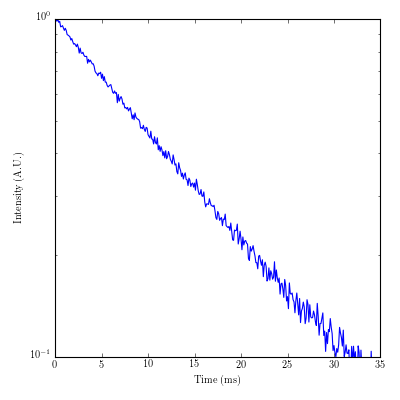

In [5]:
# User input
pump = 1    # Pump time (ms)
file = './T2_1mspump_250sweeps'  # File name with lifetime data

# Load data
data = np.genfromtxt(fname=file, delimiter='\t', dtype=float, skip_header=10, usecols=(0,1))
time = data[:,0]/1E6  # Convert time from ns to ms
y = data[:,1]

# Prepare data
y -= min(y)    # Subtract background noise
y /= max(y)    # Normalise
time -= pump   # Shift time axis to account for the pump

# Drop the data while pump on - *!required for lifetime fitting*!
ind = np.where(time>=0)
time = time[ind]
y = y[ind]

# Fit the data and get the lifetime
popt = fit_decay(time, y)
tau = popt[1]
print('Lifetime is {0:.2f} ms'.format(tau))

# Simulate data with fitting parameters
y_fit = model_func(time, popt[0], tau, popt[2])

# Plot data and fit
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(time, y, label='Data')
# ax.plot(time, y_fit, 'k', label='Fit')

ax.set_yscale('log')
plt.ylim(0.1, 1)
plt.xlim(0, 35)
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
# plt.legend(fontsize = 'small')
plt.tight_layout()
plt.savefig('lifetime_T2')

# Plot Normalised Spectrum and Primary Peak

Peak at 1535.4 nm


<IPython.core.display.Javascript object>


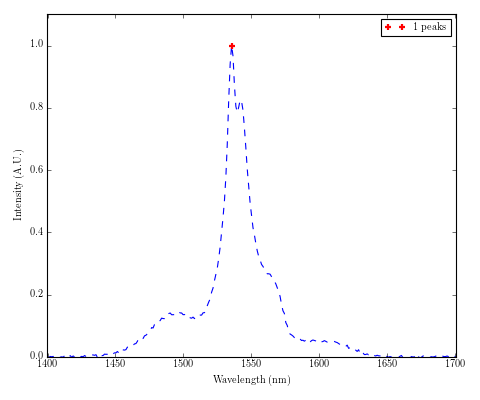

In [6]:
file = './T2.txt'    # File name with spectrum data

# Load Data
data = np.genfromtxt(fname=file, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
lam = data[:,0]
y = data[:,1]

# Prepare Data
loc = np.where((lam < 1410) | (lam > 1690))
y -= np.mean(y[loc])    # Subtract baseline from tails
y /= max(y)             # Normalise

# Find Peaks
indexes = peakutils.indexes(y, thres=0.5, min_dist=50)
lam0 = lam[indexes][0]
print('Peak at {} nm'.format(lam0))

# Plot Data
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
# ax.plot(lam, y, linewidth=3)
pplot(lam, y, indexes)
plt.ylim(0, 1.1*max(y))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (A.U.)')
plt.xlim(min(lam),max(lam))
plt.tight_layout()

<IPython.core.display.Javascript object>


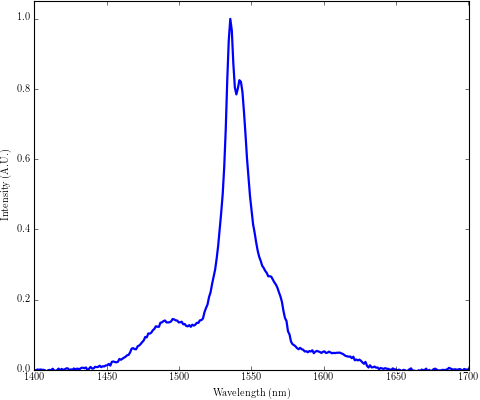

In [7]:
# Plot Data
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.plot(lam, y, lw=2)
plt.ylim(0, 1.05*max(y))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (A.U.)')
plt.xlim(min(lam),max(lam))
plt.tight_layout(pad=0.1)
plt.savefig('spectrum')

# Emission Cross Section
Calculate Emission cross section from Ladenburg-Fuchbauer equation using the fluorescence spectrum $I_e(\lambda)$:

$$
\sigma_e(\lambda) = \frac{\lambda^4_{e,peak}I_e(\lambda)}{8\pi c n^2 \tau \int I_e(\lambda) d\lambda}
$$

where $\tau$ is the lifetime of the metastable level (approximate $\tau = \tau_{rad}$). QE of 1535 nm fluorescence is typically ~100% so appropriate. Due to outerlying 5s shells shielding the intra-4f shells. 

REF: Modeling erbium-doped fiber amplifiers by Giles

In [8]:
lam0 = 1535

<IPython.core.display.Javascript object>


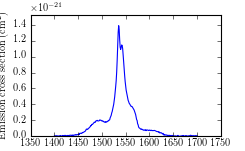

In [10]:
n = 1.56    # Refractive index of host material
QE = 0.2 

# Convert wavelength to m
lam_m = lam*nano  
lam0_m = lam0*nano

# Calculate emission cross-section
num = lam0_m**4 * y
den = 8*pi*c*(n**2)*(tau/QE*milli)*sp.integrate.simps(y, lam_m)
sig_e = num/den    # [m]

plt.figure()
plt.plot(lam, sig_e*1E4)
plt.ylim(0, 1.1*max(sig_e/centi**2))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Emission cross section (cm$^2$)')

# Calculate Absorption Cross-Section
Using McCumber Theory and developed by Miniscalo. Also known as the the method of reciprocity [Polman - Erbium emplanted thin films]. According to the McCumber theory, the absorption and stimulated emission cross-sections are related by:

$$
\sigma_e(\nu) = \sigma_a(\nu) exp[(\epsilon-h\nu)/kT ]= \sigma_a(\nu) exp[h(\nu_0-\nu)/kT]
$$

where $\epsilon$ is the net free energy required to excite one Er3+ from the $^4I_{15/2}$ state to $^4I_{13/2}$ at temperature T. In the limit of zero temperature this is the no-phonon line and hence $\epsilon = h\nu_0$ where $\nu_0$ is the frequency of the bottom $^4I_{15/2}$ state to the bottom of the $^4I_{13/2}$ transition. It is easily seen from the above equation that the emission and absorption cross sections cross at $\nu_0=\nu$.

References:
* Theory of Phonon-Terminated Optical Masers by D. McCumber <br> 
* General procedure for the analysis of Er3+ cross sections by Miniscalco, W. J. Quimby, R. S. <br>
* Optical and spectroscopic properties of erbium-activated modified silica glass with 1.54 μm high quantum efficiency by V. Benoit

<IPython.core.display.Javascript object>


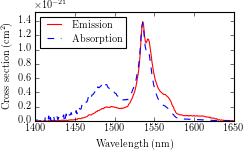

In [17]:
RT = 25       # Room temperature that measurement performed at (degrees)
T = C2K(RT)   # Temperature in kelvin

v0 = lambda2nu(1535*nano)  # No-phonon frequency (estimation)
v = lambda2nu(lam*nano)
sig_a = sig_e*exp((h*(v-v0))/(k*T))

fig = plt.figure()
plt.plot(lam, sig_e/centi**2, 'r-', label='Emission')
plt.plot(lam, sig_a/centi**2, 'b--', label='Absorption')
plt.legend(loc='best') # fontsize = 'small'
plt.ylim(0, 1.1*max(sig_e/centi**2))
plt.xlim(min(lam),1650)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Cross section (cm$^2$)')

fig.tight_layout(pad=0.1)  # Make the figure use all available whitespace  
fig.savefig('cross_sections')  

In [9]:
# Find Peaks
indexes = peakutils.indexes(sig_e/centi**2, thres=0.5, min_dist=50)
pk = sig_e[indexes][0]/centi**2
lam0 = lam[indexes][0]
print('Emission peak at {} nm with value of {:g} cm^2'.format(lam0, pk))

# Find Peaks
indexes = peakutils.indexes(sig_a/centi**2, thres=0.5, min_dist=50)
pk = sig_a[indexes][0]/centi**2
lam0 = lam[indexes][0]
print('Absorption peak at {} nm with value of {:g} cm^$'.format(lam0, pk))

Emission peak at 1535.4 nm with value of 1.39368e-21 cm^2
Absorption peak at 1535.4 nm with value of 1.38231e-21 cm^$


## Estimation of $\epsilon$

$\epsilon$ was determined by using the procedure developed by Miniscalco and Quimby.

In room-temperature measurements the peaks of the absorption and emission spectra are almost always within 1 nm of each other. Low-temperature measurements confirm that this wavelength corresponds to transitions between the lowest component of each manifold. We therefore take $E_0$ as the average of the emission and absorption peaks:

$$
E_0 = \frac{\sigma_{e,peak} + \sigma_{a,peak}}{2} \approx \sigma_{e,peak}
$$

The high-energy half-width of the emission spectrum gives the width of the excitated state manifold, $6E_2$.

In [36]:
ind = np.where(abs(y-0.95) < 0.05)
cutoff = lam[ind]
lam[ind]

array([ 1534.35,  1536.45])

In [37]:
half_fwhm = abs(cutoff[0] - cutoff[-1])/2
print('FWHM is {:g} nm'.format(half_fwhm))

FWHM is 1.05 nm


In [38]:
E2 = h*c*(1/(lam[0]*nano)-1/(lam0*nano))

### Comparison to literature values
Reference: 
* [1] Spectral properties and thermal stability of Er3+-doped oxyfluoride silicate glasses for broadband optical amplifier - Xu, Shiqing
* [2] Erbium-doped tellurite glasses with high quantum efficiency and broadband stimulated emission cross section at 1.5 μm

|           | $\sigma_{e,peak}$ | FWHM (nm) | Reference |
|:---------:|:-----------------:|:---------:|-----------|
| Silicate  | 5.5               | 40        | [1]       |
| Tellurite | 6.5               | 65        | [1]       |
| Tellurite | 8-9^             | 65        | [2]       |

^ The materials had high refractive index. The stimulated emission cross section of rare earth ions increases with the refractive index as $(n^2+2)^2/n$ for electric dipole transitions, and as n for magnetic dipole transitions.

### Notes
* A longer radiative lifetime results in smaller cross sections. Assuming $\tau_{rad}=\tau_{measured}$, however the radiative is likely to be higher. Could approximate by using a QE of 90%? Otherwise need to calculate from Jud-Ofelt theory - see [2].
* See 'In defence of the McCumber relation for erbium-doped silica and other laser glasses' for justification of using theory in silicate glasses etc. "Nevertheless, as with peak wavelength, it seems rea- sonable to expect to be a robust feature of the transition, with little variation from one fiber to the next. In this case it is probably sufficient for practical determination of gain to estimate based on historical data." Use their value of 1535 then?

# Misc

Same calculation but in better units

$$k_BT / hc = 200 [cm^{-1}]$$

$$h\Delta\nu = hc\Delta\tilde{\nu} $$

Therefore:

$$ \frac{h\Delta\nu}{k_BT} = \frac{\Delta\tilde{\nu}}{200};\qquad  \tilde{\nu} [cm^{-1}] = \frac{1}{\lambda [cm]} $$

<IPython.core.display.Javascript object>


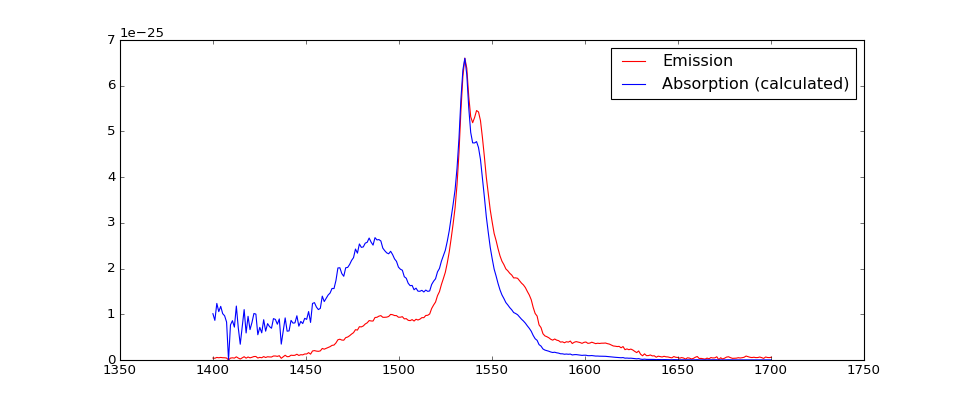

In [81]:
lam_cm = lam * 1E-7
lam0_cm = lam0 * 1E-7

dl = 1/lam_cm - 1/lam0_cm

sig_a = sig_e*exp(dl/200)
plt.figure(figsize=(12,5))
plt.plot(lam, sig_e, 'r', label='Emission')
plt.plot(lam, sig_a, 'b', label='Absorption (calculated)')
plt.legend()